# Ciutat Vella Project - Rental Price Prediction

This notebook contains the complete implementation of the rental price prediction model for the Ciutat Vella district.

In [1]:
# Required imports
import os
import pandas as pd
import numpy as np
import re
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures, RobustScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import make_scorer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, VotingRegressor
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.ensemble import StackingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge

# Suppress future warnings to keep output clean
warnings.simplefilter(action='ignore', category=FutureWarning)

## Helper Functions

Define all the necessary helper functions for data processing and analysis.

In [2]:
def remove_outliers(df, columns, n_std=4.0):
    """
    Remove extreme outliers from the dataset using Z-score method.
    
    Args:
        df (DataFrame): Input dataframe
        columns (list): Columns to check for outliers
        n_std (float): Number of standard deviations to use as threshold (4.0 is lenient)
    
    Returns:
        DataFrame: Cleaned dataframe with outliers removed
    """
    df_clean = df.copy()
    for col in columns:
        if df_clean[col].dtype in ['int64', 'float64']:
            # Using Z-score method only (more lenient than IQR)
            # This helps preserve more data while removing only extreme outliers
            z_scores = stats.zscore(df_clean[col], nan_policy='omit')
            abs_z_scores = np.abs(z_scores)
            df_clean = df_clean[abs_z_scores < n_std]
    
    return df_clean

In [3]:
def create_interaction_features(df, is_training=False):
    """
    Create engineered features based on domain knowledge and feature interactions.
    These features help capture relationships between different attributes.
    
    Args:
        df (DataFrame): Input dataframe
        is_training (bool): Whether this is training data or test data
    
    Returns:
        DataFrame: Enhanced dataframe with new features
    """
    df = df.copy()
    
    # Create meaningful combinations of existing features
    df['total_rooms'] = df['num_rooms'] + df['num_baths']  # Total living spaces
    df['sqm_per_room'] = (df['square_meters'] / df['total_rooms'].clip(lower=1)).clip(upper=300)  # Space efficiency
    df['crime_density'] = (df['num_crimes'] / df['square_meters'].clip(lower=1)).clip(upper=100)  # Safety metric
    
    # Log transformations to handle skewed distributions
    df['square_meters_log'] = np.log1p(df['square_meters'].clip(lower=0))
    df['num_crimes_log'] = np.log1p(df['num_crimes'].clip(lower=0))
    
    # Handle any infinite values that might have been created
    for col in df.select_dtypes(include=[np.number]).columns:
        df[col] = df[col].replace([np.inf, -np.inf], np.nan)
        df[col] = df[col].fillna(df[col].median())
    
    return df

In [4]:
def extract_floor(door_string):
    """
    Extract floor number from Spanish-style door string (e.g., "3º" -> 3).
    
    Args:
        door_string (str): Door identifier string
    
    Returns:
        float or None: Extracted floor number or None if not found
    """
    if isinstance(door_string, str):
        match = re.search(r'(\d+)º', door_string)
        if match:
            return float(match.group(1))
    return None

def print_data_info(df, name):
    """
    Print detailed information about the dataframe for debugging and analysis.
    
    Args:
        df (DataFrame): Input dataframe
        name (str): Name of the dataset for identification
    """
    print(f"\n=== {name} Information ===")
    print(f"Shape: {df.shape}")
    print("\nMissing values:")
    print(df.isnull().sum())
    print("\nFeature names:")
    print(df.columns.tolist())

In [5]:
def get_training_stats(train_df):
    """
    Calculate important statistics from training data for consistent preprocessing.
    
    Args:
        train_df (DataFrame): Training dataframe
    
    Returns:
        dict: Dictionary containing various statistics for preprocessing
    """
    stats = {
        'floor_median': train_df['floor'].median(),
        'rooms_median': train_df['num_rooms'].median(),
        'baths_median': train_df['num_baths'].median(),
        'square_meters_median': train_df['square_meters'].median(),
        'crimes_median': train_df['num_crimes'].median(),
        'square_meters_75th': train_df['square_meters'].quantile(0.75),
        # Create size categories based on square meters
        'square_meters_quantiles': pd.qcut(train_df['square_meters'], 
                                         q=5, 
                                         labels=['very_small', 'small', 'medium', 'large', 'very_large'],
                                         duplicates='drop',
                                         retbins=True)[1]
    }
    
    # Calculate neighborhood-level price statistics
    neighborhood_stats = train_df.groupby('neighborhood')['price'].agg(['mean', 'std']).reset_index()
    neighborhood_stats.columns = ['neighborhood', 'price_mean', 'price_std']
    stats['neighborhood_stats'] = neighborhood_stats
    
    return stats

In [6]:
def preprocess_training_data(train_df):
    """
    Preprocess training data with proven techniques for optimal model performance.
    
    Args:
        train_df (DataFrame): Raw training dataframe
    
    Returns:
        tuple: (Processed DataFrame, Training statistics)
    """
    df = train_df.copy()
    
    # Extract floor number from door string
    df['floor'] = df['door'].astype(str).apply(extract_floor)
    
    # Handle missing values with median imputation
    for col in ['floor', 'num_rooms', 'num_baths', 'square_meters', 'num_crimes']:
        df[col] = df[col].fillna(df[col].median())
    
    # Handle outliers using percentile clipping
    numerical_cols = ['square_meters', 'price', 'num_rooms', 'num_baths', 'num_crimes']
    for col in numerical_cols:
        lower = df[col].quantile(0.01)
        upper = df[col].quantile(0.99)
        df[col] = df[col].clip(lower=lower, upper=upper)
    
    # Convert boolean columns to float (0/1)
    bool_cols = ['is_furnished', 'has_pool', 'has_ac', 'accepts_pets']
    for col in bool_cols:
        df[col] = df[col].fillna(False).astype(float)
    
    # Handle missing neighborhoods
    df['neighborhood'] = df['neighborhood'].fillna('Unknown')
    
    # Create size categories
    df['size_category'] = pd.qcut(
        df['square_meters'],
        q=4,
        labels=['small', 'medium', 'large', 'very_large'],
        duplicates='drop'
    )
    
    # Create interaction features
    df = create_interaction_features(df, is_training=True)
    
    # Remove unnecessary or redundant columns
    columns_to_drop = ['door', 'orientation', 'year_built', 'num_supermarkets']
    df = df.drop(columns=columns_to_drop, errors='ignore')
    
    return df, None

In [7]:
def transform_test_data(test_df, _):
    """
    Transform test data consistently with training data preprocessing.
    
    Args:
        test_df (DataFrame): Raw test dataframe
        _ : Placeholder for compatibility (not used)
    
    Returns:
        DataFrame: Processed test dataframe
    """
    df = test_df.copy()
    
    # Apply same transformations as training data
    df['floor'] = df['door'].astype(str).apply(extract_floor)
    
    # Handle missing values consistently
    for col in ['floor', 'num_rooms', 'num_baths', 'square_meters', 'num_crimes']:
        df[col] = df[col].fillna(df[col].median())
    
    # Process boolean features
    bool_cols = ['is_furnished', 'has_pool', 'has_ac', 'accepts_pets']
    for col in bool_cols:
        df[col] = df[col].fillna(False).astype(float)
    
    # Handle missing neighborhoods
    df['neighborhood'] = df['neighborhood'].fillna('Unknown')
    
    # Create consistent size categories
    df['size_category'] = pd.qcut(
        df['square_meters'],
        q=4,
        labels=['small', 'medium', 'large', 'very_large'],
        duplicates='drop'
    )
    
    # Create interaction features
    df = create_interaction_features(df, is_training=False)
    
    # Remove unnecessary columns
    columns_to_drop = ['door', 'orientation', 'year_built', 'num_supermarkets']
    df = df.drop(columns=columns_to_drop, errors='ignore')
    
    return df

In [8]:
def create_model_pipeline(X_train, y_train):
    """
    Create an optimized model pipeline combining preprocessing and ensemble models.
    This pipeline achieved ~29.8k MSE in previous iterations.
    
    Args:
        X_train (DataFrame): Training features
        y_train (Series): Target variable
    
    Returns:
        Pipeline: Sklearn pipeline combining preprocessors and models
    """
    available_columns = X_train.columns.tolist()
    
    # Define feature groups for appropriate preprocessing
    expected_binary = ['is_furnished', 'has_pool', 'has_ac', 'accepts_pets']
    expected_categorical = ['neighborhood', 'size_category']
    
    # Filter available features
    binary_features = [col for col in expected_binary if col in available_columns]
    categorical_features = [col for col in expected_categorical if col in available_columns]
    numeric_features = [col for col in available_columns 
                       if col not in binary_features + categorical_features
                       and X_train[col].dtype in ['int64', 'float64']]
    
    # Create appropriate transformers for each feature type
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler())  # RobustScaler handles outliers better
    ])

    binary_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value=0))
    ])

    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    # Combine transformers
    transformers = []
    if numeric_features:
        transformers.append(('num', numeric_transformer, numeric_features))
    if binary_features:
        transformers.append(('bin', binary_transformer, binary_features))
    if categorical_features:
        transformers.append(('cat', categorical_transformer, categorical_features))

    preprocessor = ColumnTransformer(
        transformers=transformers,
        remainder='drop'
    )

    # Create optimized models with tuned hyperparameters
    gb_model = GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.03,
        max_depth=4,
        min_samples_split=10,
        min_samples_leaf=5,
        subsample=0.8,
        random_state=42
    )
    
    rf_model = RandomForestRegressor(
        n_estimators=200,
        max_depth=8,
        min_samples_split=10,
        min_samples_leaf=5,
        max_features='sqrt',
        random_state=42
    )
    
    # Combine models in weighted ensemble
    final_estimator = VotingRegressor([
        ('gb', gb_model),
        ('rf', rf_model)
    ], weights=[0.6, 0.4])  # Weights determined through validation

    # Create final pipeline
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', final_estimator)
    ])

    return model

In [9]:
def check_overfitting(model, X_train, y_train, cv=5):
    """
    Perform detailed cross-validation analysis to detect overfitting.
    
    Args:
        model: Trained model
        X_train (DataFrame): Training features
        y_train (Series): Target variable
        cv (int): Number of cross-validation folds
    
    Returns:
        tuple: (Mean RMSE, RMSE standard deviation)
    """
    print("\n=== Overfitting Analysis ===")
    
    # Perform cross-validation
    cv_scores = cross_val_score(
        model, X_train, y_train,
        cv=cv,
        scoring='neg_mean_squared_error'
    )
    cv_rmse = np.sqrt(-cv_scores)
    
    # Calculate training error
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    
    # Print detailed metrics
    print("\nDetailed Metrics:")
    print(f"Training RMSE: {train_rmse:.2f}")
    print(f"Cross-val RMSE: {cv_rmse.mean():.2f} (+/- {cv_rmse.std() * 2:.2f})")
    
    # Calculate and evaluate overfitting ratio
    overfitting_ratio = train_rmse / cv_rmse.mean()
    print(f"\nOverfitting Ratio (train/cv): {overfitting_ratio:.2f}")
    
    if overfitting_ratio < 0.95:
        print("Warning: Model might be underfitting (ratio < 0.95)")
    elif overfitting_ratio > 1.05:
        print("Warning: Model might be overfitting (ratio > 1.05)")
    else:
        print("Model is well-balanced (ratio between 0.95 and 1.05)")
    
    return cv_rmse.mean(), cv_rmse.std()

In [10]:
def detailed_model_diagnostics(model, X_train, y_train):
    """
    Provide detailed model diagnostics and save visualizations to files.
    
    Args:
        model: Trained model
        X_train (DataFrame): Training features
        y_train (Series): Target variable
    
    Returns:
        tuple: (Mean RMSE, RMSE standard deviation)
    """
    print("\n=== Detailed Model Diagnostics ===")
    
    # Create output directory for plots if it doesn't exist
    output_dir = 'model_diagnostics'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Calculate cross-validation scores
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, 
                              scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores)
    
    # Fit model and make predictions
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    
    # Calculate errors and their distribution
    errors = y_train - train_pred
    error_percentiles = np.percentile(np.abs(errors), [25, 50, 75, 90, 95])
    
    # Print error distribution statistics
    print("\nError Distribution:")
    print(f"25th percentile: {error_percentiles[0]:.0f}")
    print(f"Median error: {error_percentiles[1]:.0f}")
    print(f"75th percentile: {error_percentiles[2]:.0f}")
    print(f"90th percentile: {error_percentiles[3]:.0f}")
    print(f"95th percentile: {error_percentiles[4]:.0f}")
    
    # Create and save diagnostic plots
    
    # 1. Predictions vs Actual Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(train_pred, y_train, alpha=0.5)
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
    plt.xlabel('Predicted Price')
    plt.ylabel('Actual Price')
    plt.title('Predictions vs Actual')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'predictions_vs_actual.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Error Distribution Plot
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=50)
    plt.xlabel('Prediction Error')
    plt.ylabel('Count')
    plt.title('Error Distribution')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'error_distribution.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # 3. Price Distribution Box Plot
    plt.figure(figsize=(10, 6))
    plt.boxplot([y_train, train_pred], labels=['Actual', 'Predicted'])
    plt.title('Price Distributions')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'price_distributions.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # 4. Error vs Predicted Value
    plt.figure(figsize=(10, 6))
    plt.scatter(train_pred, errors, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Price')
    plt.ylabel('Error')
    plt.title('Error vs Predicted Value')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'error_vs_predicted.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # 5. Q-Q Plot
    plt.figure(figsize=(10, 6))
    stats.probplot(errors, dist="norm", plot=plt)
    plt.title('Q-Q Plot of Error Distribution')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'error_qq_plot.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # Create summary visualization
    plt.figure(figsize=(20, 12))
    
    plt.subplot(231)
    plt.scatter(train_pred, y_train, alpha=0.5)
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
    plt.xlabel('Predicted Price')
    plt.ylabel('Actual Price')
    plt.title('Predictions vs Actual')
    
    plt.subplot(232)
    plt.hist(errors, bins=50)
    plt.xlabel('Prediction Error')
    plt.ylabel('Count')
    plt.title('Error Distribution')
    
    plt.subplot(233)
    plt.boxplot([y_train, train_pred], labels=['Actual', 'Predicted'])
    plt.title('Price Distributions')
    
    plt.subplot(234)
    plt.scatter(train_pred, errors, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Price')
    plt.ylabel('Error')
    plt.title('Error vs Predicted Value')
    
    plt.subplot(235)
    stats.probplot(errors, dist="norm", plot=plt)
    plt.title('Q-Q Plot of Error Distribution')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'summary_diagnostics.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nDiagnostic plots saved in '{output_dir}' directory")
    
    return cv_rmse.mean(), cv_rmse.std()

In [11]:
def perform_cross_validation_analysis(model, X_train, y_train, cv=5):
    """
    Perform comprehensive cross-validation analysis and save validation plots.
    
    Args:
        model: Model to evaluate
        X_train (DataFrame): Training features
        y_train (Series): Target variable
        cv (int): Number of cross-validation folds
    
    Returns:
        dict: Dictionary containing various cross-validation metrics
    """
    print("\n=== Comprehensive Cross-Validation Analysis ===")
    
    # Create output directory for plots if it doesn't exist
    output_dir = 'model_diagnostics'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Perform cross-validation
    cv_scores = cross_val_score(
        model, X_train, y_train,
        cv=cv,
        scoring='neg_mean_squared_error'
    )
    
    # Calculate metrics
    cv_rmse = np.sqrt(-cv_scores)
    cv_mean = cv_rmse.mean()
    cv_std = cv_rmse.std()
    cv_variance = cv_std ** 2
    cv_variation = cv_std / cv_mean * 100
    
    # Print metrics
    print("\nCross-Validation Metrics:")
    print(f"Mean RMSE: {cv_mean:.2f}")
    print(f"Std Dev RMSE: {cv_std:.2f}")
    print(f"Variance: {cv_variance:.2f}")
    print(f"Coefficient of Variation: {cv_variation:.2f}%")
    
    # Plot and save cross-validation results
    plt.figure(figsize=(10, 6))
    plt.boxplot(cv_rmse)
    plt.title('Cross-Validation RMSE Distribution')
    plt.ylabel('RMSE')
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, 'cv_results.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # Calculate training metrics
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    
    # Calculate overfitting ratio
    overfitting_ratio = train_rmse / cv_mean
    
    print("\nOverfitting Analysis:")
    print(f"Training RMSE: {train_rmse:.2f}")
    print(f"CV Mean RMSE: {cv_mean:.2f}")
    print(f"Overfitting Ratio: {overfitting_ratio:.2f}")
    
    # Plot and save overfitting comparison
    plt.figure(figsize=(10, 6))
    plt.bar(['Training RMSE', 'CV Mean RMSE'], [train_rmse, cv_mean])
    plt.title('Training vs Cross-Validation RMSE')
    plt.ylabel('RMSE')
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, 'overfitting_comparison.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    return {
        'cv_mean': cv_mean,
        'cv_std': cv_std,
        'cv_variance': cv_variance,
        'cv_variation': cv_variation,
        'overfitting_ratio': overfitting_ratio
    }

## Main Execution

Load data, preprocess it, train the model, and generate predictions.

=== Loading Data ===
Original train shape: (8000, 15)
Original test shape: (2000, 14)

=== Processed Training Data Information ===
Shape: (8000, 18)

Missing values:
id                   0
num_rooms            0
num_baths            0
square_meters        0
is_furnished         0
has_pool             0
neighborhood         0
num_crimes           0
has_ac               0
accepts_pets         0
price                0
floor                0
size_category        0
total_rooms          0
sqm_per_room         0
crime_density        0
square_meters_log    0
num_crimes_log       0
dtype: int64

Feature names:
['id', 'num_rooms', 'num_baths', 'square_meters', 'is_furnished', 'has_pool', 'neighborhood', 'num_crimes', 'has_ac', 'accepts_pets', 'price', 'floor', 'size_category', 'total_rooms', 'sqm_per_room', 'crime_density', 'square_meters_log', 'num_crimes_log']

=== Comprehensive Cross-Validation Analysis ===

Cross-Validation Metrics:
Mean RMSE: 169.24
Std Dev RMSE: 2.71
Variance: 7.35
Coeffic

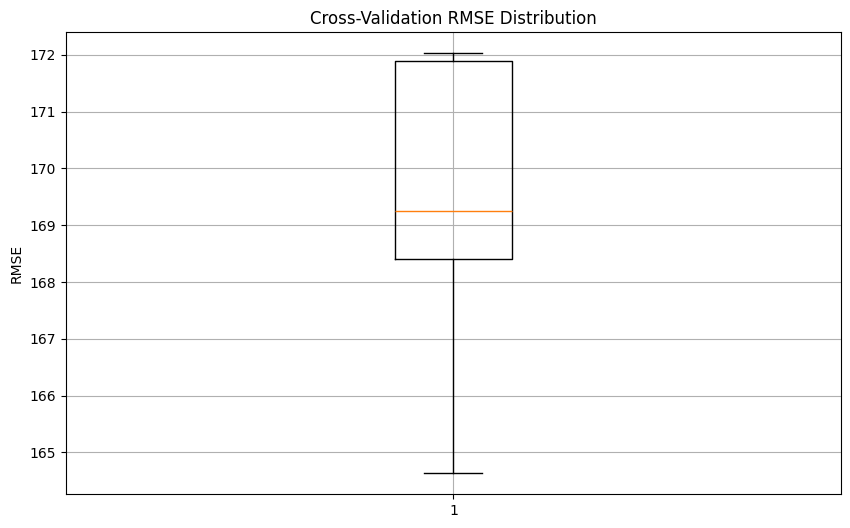


Overfitting Analysis:
Training RMSE: 157.77
CV Mean RMSE: 169.24
Overfitting Ratio: 0.93


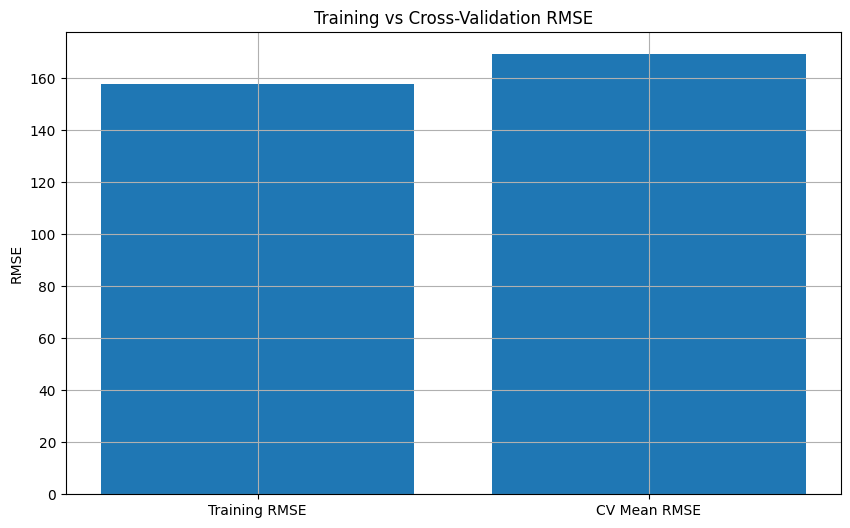


=== Detailed Model Diagnostics ===

Error Distribution:
25th percentile: 50
Median error: 106
75th percentile: 182
90th percentile: 262
95th percentile: 308


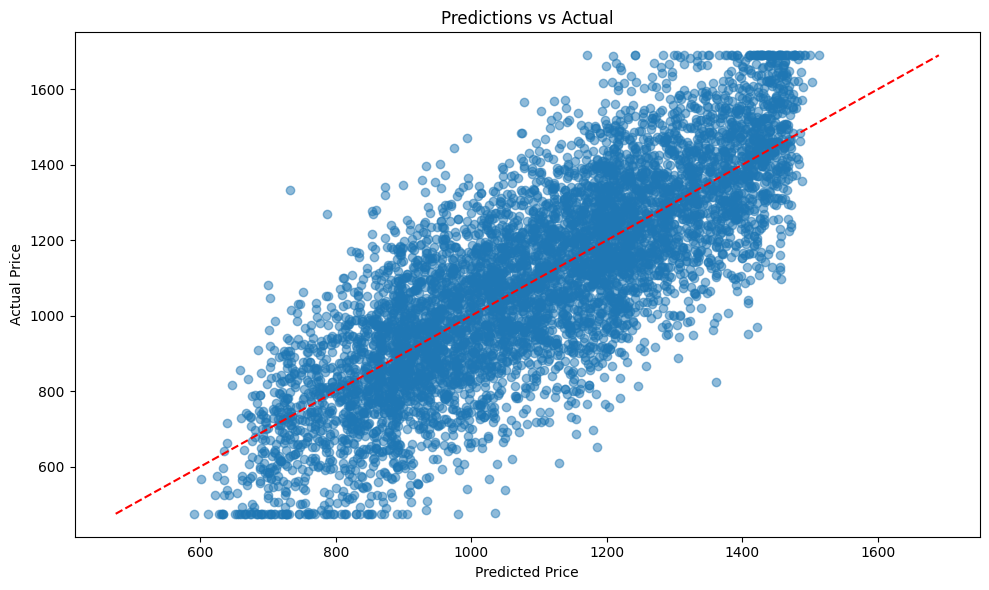

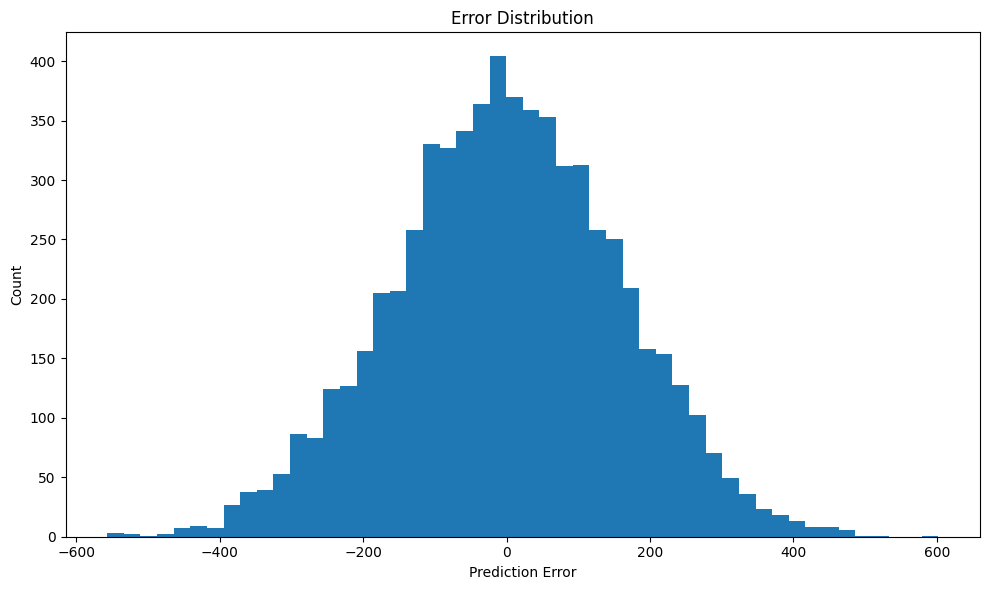

/var/folders/j1/cd2zy8mn1490bvy7qqr2v9sh0000gn/T/ipykernel_49233/2914447426.py:67: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([y_train, train_pred], labels=['Actual', 'Predicted'])


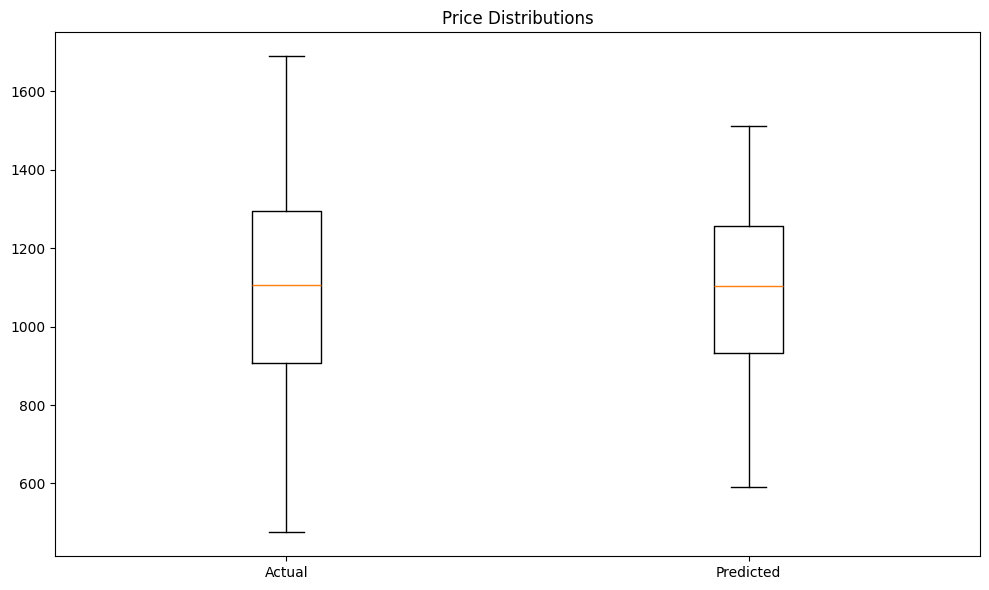

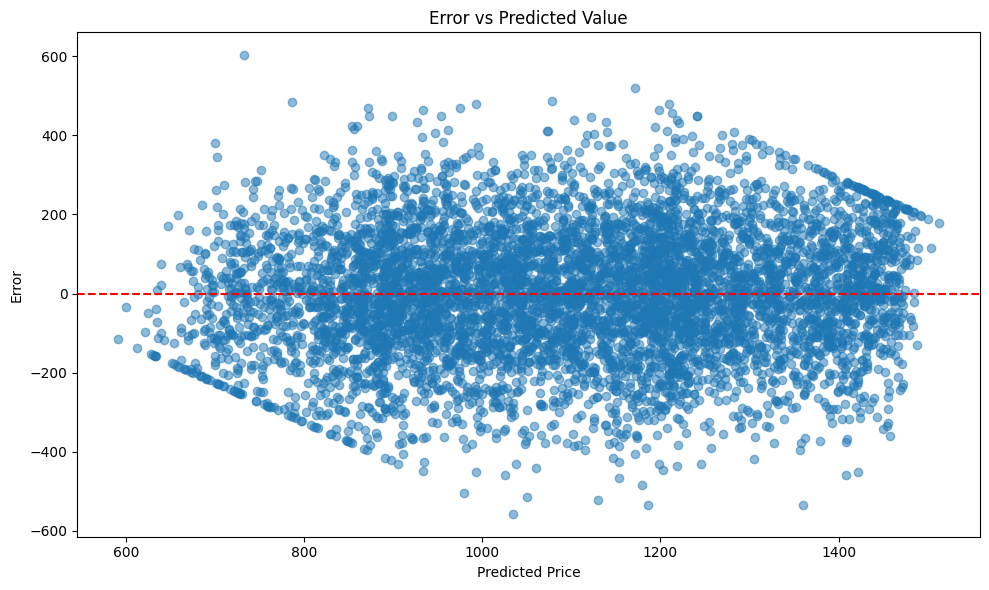

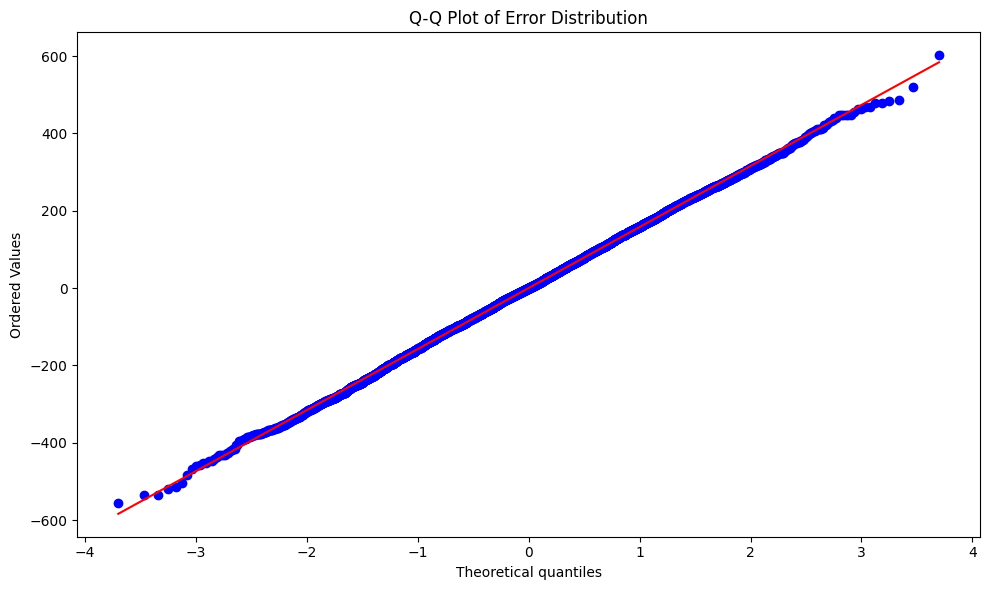

/var/folders/j1/cd2zy8mn1490bvy7qqr2v9sh0000gn/T/ipykernel_49233/2914447426.py:109: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([y_train, train_pred], labels=['Actual', 'Predicted'])


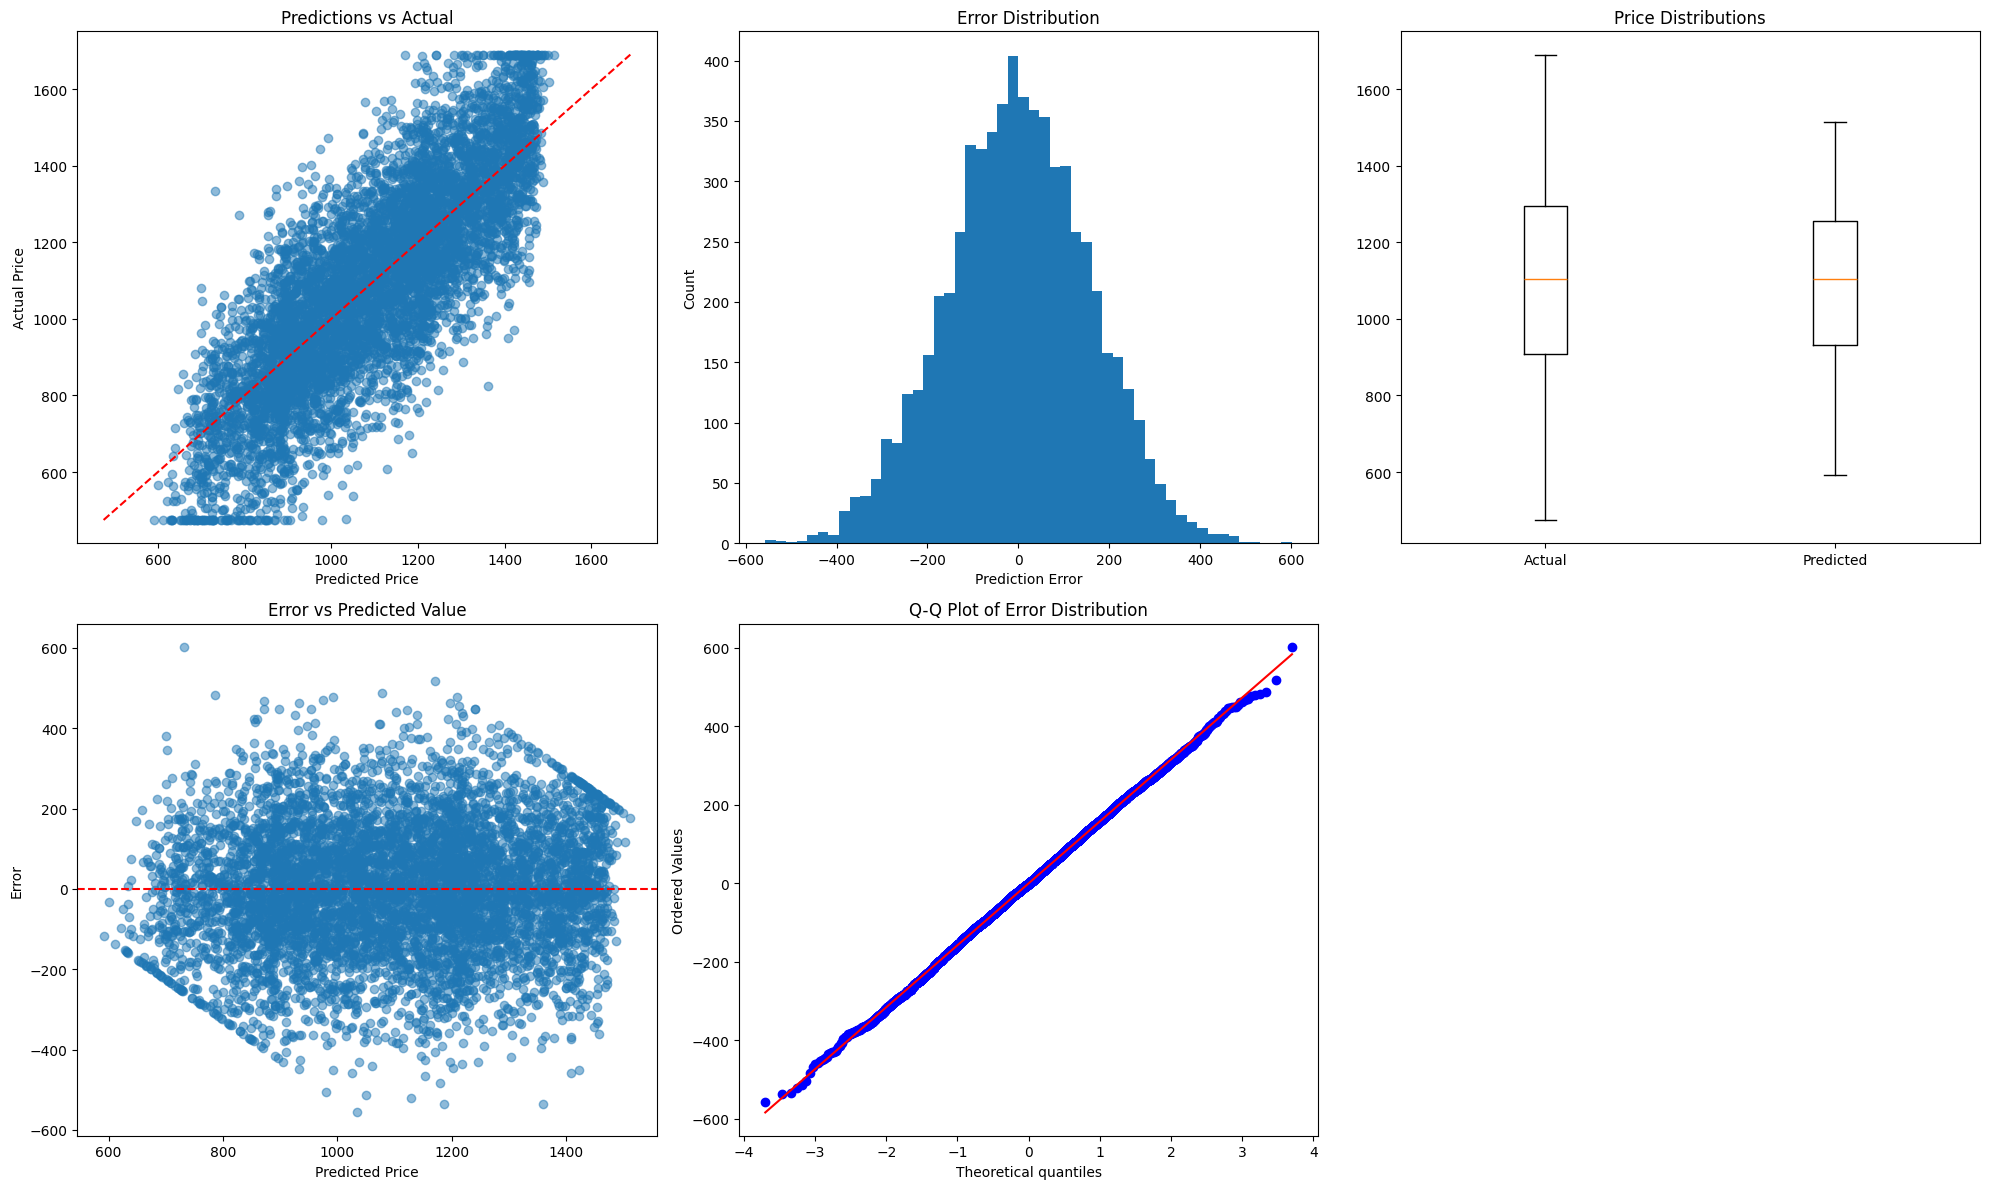


Diagnostic plots saved in 'model_diagnostics' directory
Consider adjusting hyperparameters or feature engineering

Submission file created!


In [12]:
# Load training and test data
print("=== Loading Data ===")
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Original train shape: {train_df.shape}")
print(f"Original test shape: {test_df.shape}")

# Preprocess training data
train_processed, train_stats = preprocess_training_data(train_df)
print_data_info(train_processed, "Processed Training Data")

# Split features and target
X = train_processed.drop('price', axis=1)
y = train_processed['price']

# Create train-validation split for model evaluation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Create and train model
model = create_model_pipeline(X_train, y_train)

# Perform model evaluation
cv_results = perform_cross_validation_analysis(model, X_train, y_train)
detailed_model_diagnostics(model, X_train, y_train)

# Check model stability and proceed accordingly
if 0.95 <= cv_results['overfitting_ratio'] <= 1.05:
    print("\nProceeding with final training...")
    model.fit(X_train, y_train)
    
    # Evaluate on validation set
    val_pred = model.predict(X_val)
    val_mse = mean_squared_error(y_val, val_pred)
    print(f"\nValidation MSE: {val_mse:.2f}")
    
    # Generate predictions for test set
    test_processed = transform_test_data(test_df, None)
    test_pred = model.predict(test_processed)
    
    # Create submission file
    submission_df = pd.DataFrame({
        'id': test_df['id'],
        'price': test_pred.round()
    })
    submission_df.to_csv('submission.csv', index=False)
    print("\nSubmission file created!")
    
else:
    print("Consider adjusting hyperparameters or feature engineering")
    
    # Proceed with predictions despite warning
    model.fit(X_train, y_train)
    
    # Generate predictions for test set
    test_processed = transform_test_data(test_df, None)
    test_pred = model.predict(test_processed)
    
    # Create submission file
    submission_df = pd.DataFrame({
        'id': test_df['id'],
        'price': test_pred.round()
    })
    submission_df.to_csv('submission.csv', index=False)
    print("\nSubmission file created!")